# I/O sequencing with `NidaqSequencer`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qdlutils.hardware.nidaq.synchronous.nidaqsequencer import NidaqSequencer
from qdlutils.hardware.nidaq.synchronous.nidaqsequencerinput import *
from qdlutils.hardware.nidaq.synchronous.nidaqsequenceroutput import *

We want to read in voltages and counts via an analog input and counter input on the DAQ. Thus we
instantiate classes to represent these data sources and store them in a dictionary with they key 
describing their purpose. The keys are meant for the user to easily find the results and so they
should be straightforward to understand.

In [2]:
inputs = {
    'ai_voltage' : NidaqSequencerAIVoltage(
            name = 'ai_voltage',
            device = 'Dev1',
            channel = 'ai1',
    ),
    'ci_edge' : NidaqSequencerCIEdge(
            name = 'ci_edge',
            device = 'Dev1',
            channel = 'ctr2',
            terminal = 'PFI0',
    )
}

Likewise for the outputs, here we want to output an analog voltage signal, our device is limited to -3 V to 5 V for safety.

In [3]:
outputs = {
    'ao_voltage' : NidaqSequencerAOVoltage(
            name = 'ao_voltage',
            device = 'Dev1',
            channel = 'ao3',
            min_voltage = -3,
            max_voltage = 5
    ),
}

Now we can generate the data. For this notebook, data is generated by linearly sweeping the AO 
voltage signal to tune a piezo on a laser. This produces a sinusoidal-like oscillation in the laser
power which we detect on a photodiode via the analog input and recording the laser reflection via
edge counting TTL pulses from a SPCM.

In [4]:
# Number of samples in the sequence
n_samples = 256

# Total sequence time in seconds
sequence_time = 4

# Start and stop voltage of the sweep
start_voltage = -3
stop_voltage = 5

# Rate of samples per second
sample_rate = n_samples / sequence_time

# Generate the data
data = np.linspace(start_voltage,stop_voltage, n_samples)

# Save in a dictionary to configure the sequencer
output_data = {'ao_voltage' : data}

In this example, let us record the same number of points as the data samples. We'll also add a delay
of 2 clock cycles to each channel.

In [5]:
input_samples = {
    'ai_voltage' : n_samples,
    'ci_edge': n_samples
}
readout_delays = {
    'ai_voltage' : 1,
    'ci_edge' : 1
}

Instantiate the sequencer

In [6]:
sequencer = NidaqSequencer(
        inputs= inputs,
        outputs=outputs,
        clock_device = 'Dev1',
        clock_channel = 'port0'
)

As a convenience, the sequencer method `check_sequencer()` returns a figure illustrating the various
output and input source datastreams during the sequence. Output datastreams are plotted directly and
the input datastreams are represented by a binary signal where a `1` indicates a sample where the 
input source is actively measuring.

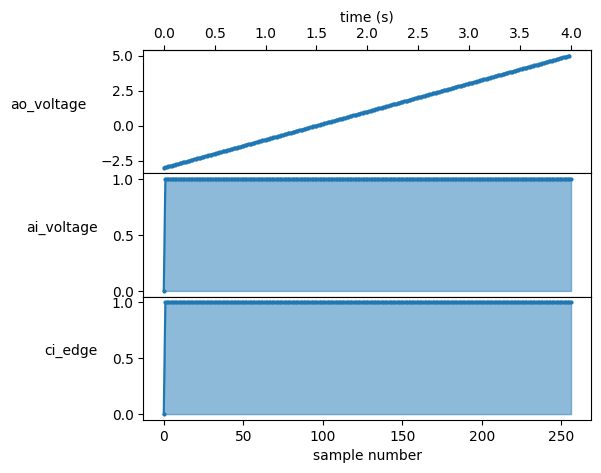

In [7]:
fig = sequencer.check_sequence(
        clock_rate = sample_rate,
        output_data = output_data,
        input_samples = input_samples,
        readout_delays = readout_delays,
)

Now we can run the sequence:

In [7]:
sequencer.run_sequence(
        clock_rate = sample_rate,
        output_data = output_data,
        input_samples = input_samples,
        readout_delays = readout_delays,
        soft_start = True
)

To access the data we may utilize the `get_data()` method. Here let us get everything (default behavior).

In [8]:
# Get the results
results = sequencer.get_data()

# Process the results
output_voltage = results['ao_voltage']
input_voltage = results['ai_voltage']
input_counts = results['ci_edge']
# Get the count rate from the raw edge counts
count_rate = np.diff(input_counts, prepend=0) * sample_rate

Plot the results:

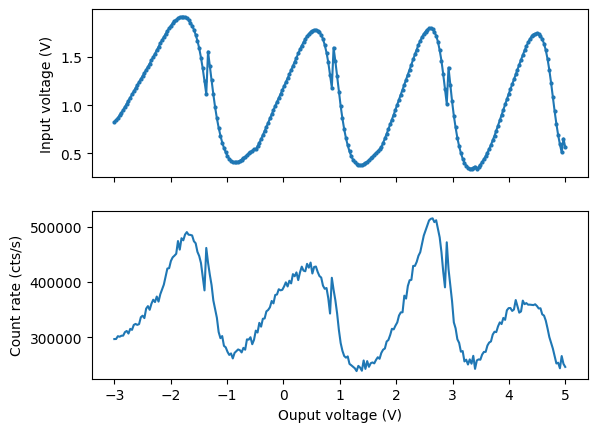

In [9]:
# Plot the results
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(output_voltage, input_voltage, 'o-', markersize=2, label='AI data')
ax[1].plot(output_voltage, count_rate, label='count rate')
ax[1].set_xlabel('Ouput voltage (V)')
ax[0].set_ylabel('Input voltage (V)')
ax[1].set_ylabel('Count rate (cts/s)')
plt.show()